In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier

首先恭喜各位，通过第一轮的简历筛选，进入线上测试环节。

通过这次线上测试，希望大家能够在限定的时间内，尽自己最大努力，完成一些数据处理和数据建模任务，展现自己对机器学习建模工作的熟悉程度。

## 任务说明
请在这个jupyter notebook中
* 补充完成任务所需要的python代码。可以直接在code cell中编写代码；或者将代码写在.py文件中后在这个notebook中import使用
* 利用markdown cell回答相关的问题或者解释分析思路

完成后，在github上建立一个repo。将这个notebook，相关的.py文件，保存处理结果的excel文件等，push到建立的repo。将repo链接提交给面试官。

## 截止时间
任务的截止提交时间为:

**2019-05-21 10:00:00 a.m**

## 注意事项：
1. 使用python3.6以上版本，如果使用```pandas```等python库，请先升级到最新版本。
2. 请确保面试官在clone各位发布的repo后，能够跑通这个notebook中的代码。
3. 除了实现任务所需的功能，编写的代码具有高可维护性，也是我们非常希望候选人具备的能力。（可参考Refactoring by Kent Beck and Martin Fowler一书中关于"bad code smell"的讨论）
4. 这个测试的目的是检验候选人是否具备高效的完成建模相关工作的能力，不鼓励重复造轮子。建议充分利用```pandas```, ```sklearn```等已有python库完成任务。
5. 请展现自己真实的能力，不要请人代劳。如果候选人试用期阶段表现的实际工作能力明显低于线上测试表现的能力，候选人会被认为采用非诚信手段通过线上测试，将予以坚决辞退。
6. 职场中，Deadline是非常严肃的。无论完成度如何，请务必在截止时间前，提交自己的结果。逾期提交将不予受理。

## 机器学习建模（任务1～任务4）
以下任务基于虚拟的建模数据dataset.csv

建模数据集构成
* id：样本的编号
* dataset：划分了哪些数据用于train, 那些用于test
* label:  0或者1, 只有train数据才给出了label
* 其实字母f开头的列为建模特征

# 数据清洗

In [2]:
import pandas as pd
model_data = pd.read_csv('model_data.csv')

### 任务1
对dataset中的建模数据进行分析，描述这个数据集的特点。

例如
* 样本量，特征量
* 建模特征缺失率的分布

候选人请追加其他认为有必要进行的分析，并配合数据可视化手段，支持自己的结论。
 

In [3]:
model_data.shape

(3793, 3277)

In [4]:
model_data.notnull().sum().sort_values(ascending=False)
#存在很多缺失值

dataset    3793
id         3793
f_0209     3793
f_0208     3790
f_0217     3777
f_0216     3773
f_0257     3580
f_0256     3531
f_0211     3515
f_0215     3515
f_2928     3454
f_2796     3454
f_2754     3454
f_2760     3454
f_0998     3454
f_2910     3454
f_1808     3454
f_2916     3454
f_1796     3454
f_1022     3454
f_2778     3454
f_1814     3454
f_2784     3454
f_2790     3454
f_1820     3454
f_0326     3454
f_1802     3454
f_1004     3454
f_2904     3454
f_1760     3454
           ... 
f_1739        0
f_1740        0
f_1741        0
f_1742        0
f_1743        0
f_1744        0
f_1745        0
f_1746        0
f_1747        0
f_1748        0
f_1875        0
f_1876        0
f_1877        0
f_1878        0
f_1879        0
f_1880        0
f_1881        0
f_1882        0
f_1883        0
f_1884        0
f_1885        0
f_1886        0
f_1887        0
f_1888        0
f_1889        0
f_1890        0
f_1891        0
f_1892        0
f_1893        0
f_0000        0
Length: 3277, dtype: int

In [5]:
#划分数据集
df_train=model_data[model_data["dataset"]=="train"]
df_train=df_train.reindex(df_train['id'])
df_test=model_data[model_data["dataset"]=="test"]
df_test=df_test.reindex(df_test['id'])

In [6]:
df_train.shape,df_test.shape

((3000, 3277), (793, 3277))

In [7]:
#大部分数据缺失，删除数据缺失值较多的特征
c=[]
for i in df_train.columns:
    if ((df_train[i].notnull().sum()))/df_train.shape[1]>=0.5:
        c.append(i)
df_train_1=df_train[c]

In [8]:
#对训练数据进行缺失值处理
#用平均值填充
x_train=df_train_1.iloc[:,:-3]
y_train=df_train_1['label']
x_train=x_train.fillna(x_train.mean())

In [9]:
#对测试数据进行缺失值处理
x_test=df_test[df_train_1.columns].iloc[:,:-3]
x_test=x_test.fillna(x_train.mean())

In [10]:
x_train.shape,x_test.shape

((3000, 590), (793, 590))

In [11]:
#目标变量分布情况
df_train.label.value_counts()

0.0    2684
1.0     316
Name: label, dtype: int64

<BarContainer object of 2 artists>

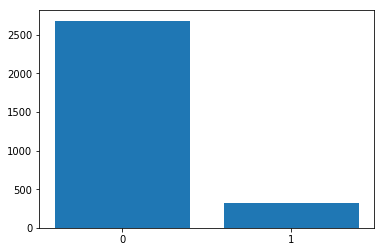

In [12]:
plt.bar(x=('0','1'),height=(2684,316))

# 特征选择和建模

In [16]:
X=x_train.values
Y=y_train.values

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [71]:
X_train.shape,X_test.shape

((2400, 590), (600, 590))

### 任务2

请根据train数据，使用3种指定的机器学习算法（都可以在sklearn中找到）分别训练模型。这3种算法是
* xgboost
* logistic regression
* random forest

要求:
* 预测目标为label列
* 模型优化的目标为auc_roc
* 需要对特征进行筛选。每种算法训练的模型，最后使用的特征控制在20个以内。
* 每种算法得到的模型，将模型在test数据集的预测结果(0~1之间的一个分值)保存在csv文件中。面试官会计算候选人模型在test数据集的auc_roc

# 随机森林模型

In [97]:
rf0= RandomForestClassifier(oob_score=True, random_state=10)
rf0.fit(X_train,Y_train)
y_predprob = rf0.predict_proba(X_test)[:,1]
rf0.oob_score_,roc_auc_score(Y_test,y_predprob)

(0.9091666666666667, 0.8560747928725457)

In [87]:
param_test1 = {'n_estimators':range(10,100,10)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt' ,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 90}, 0.8796837209302326)

In [88]:
param_test2 = {'max_depth':range(3,15,2), 'min_samples_split':range(50,201,20)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 90, 
                                  min_samples_leaf=20,max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(X_train,Y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 13, 'min_samples_split': 50}, 0.8907255813953487)

In [101]:
rf1 = RandomForestClassifier(n_estimators= 90, max_depth=13, min_samples_split=50,
                                  min_samples_leaf=20,max_features='sqrt' ,oob_score=True, random_state=10)
rf1.fit(X_train,Y_train)
y_predprob = rf1.predict_proba(X_test)[:,1]
rf1.oob_score_,roc_auc_score(Y_test,y_predprob)

(0.9041666666666667, 0.8812563840653728)

In [103]:
param_test3 = {'min_samples_split':range(80,150,20), 'min_samples_leaf':range(10,60,10)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 90, max_depth=13,
                                  max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 10, 'min_samples_split': 80}, 0.8858139534883721)

In [135]:
param_test4 = {'max_features':range(10,20,2)}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 90, max_depth=13, min_samples_split=50,
                                  min_samples_leaf=20 ,oob_score=True, random_state=10),
   param_grid = param_test4, scoring='roc_auc',iid=False, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 16}, 0.891553488372093)

In [140]:
rf2 = RandomForestClassifier(n_estimators= 90, max_depth=13, min_samples_split=50,
                                  min_samples_leaf=20,max_features=21,oob_score=True, random_state=10)
rf2.fit(X_train,Y_train)
y_predprob = rf2.predict_proba(X_test)[:,1]
rf2.oob_score_,roc_auc_score(Y_test,y_predprob)

(0.9029166666666667, 0.8853138122801043)

In [148]:
X_test_new=x_test.values

In [149]:
rf3=rf2 = RandomForestClassifier(n_estimators= 90, max_depth=13, min_samples_split=50,
                                  min_samples_leaf=20,max_features=21,oob_score=True, random_state=10)
rf3.fit(X,Y)
y_pred1=rf3.predict(X_test_new)

In [ ]:
X=x_train.values
Y=y_train.values

In [187]:
dtrain=df_train_1.drop(columns=['id','dataset'])
target='label'

# XGBoost模型

In [217]:
#调参
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gs1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8,             colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4,     scale_pos_weight=1, seed=27), 
 param_grid = param_test1,     scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gs1.fit(X,Y)
gs1.best_params_,gs1.best_score_

({'max_depth': 5, 'min_child_weight': 1}, 0.9359348837209301)

In [220]:
#搜索参数max_depth，min_child_weight
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gs1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8,             colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4,     scale_pos_weight=1, seed=27), 
 param_grid = param_test1,     scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gs1.fit(X,Y)
gs1.best_params_,gs1.best_score_

({'max_depth': 7, 'min_child_weight': 3}, 0.8944740444933267)

In [225]:
gs2.best_params_,gs2.best_score_

({'max_depth': 7, 'min_child_weight': 3}, 0.8944740444933267)

In [240]:
model_1= XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=7,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model_1.fit(X_train,Y_train)
y_predprob = model_1.predict_proba(X_test)[:,1]
roc_auc_score(Y_test,y_predprob)

0.904636250141868

In [228]:
#gamma参数调优
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gs3=GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gs3.fit(X,Y)


({'gamma': 0.0}, 0.8748122085766962)

In [230]:
gs3.best_params_, gs3.best_score_

({'gamma': 0.0}, 0.8944740444933267)

In [235]:
#调整subsample 和 colsample_bytree 参数
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gs4= GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gs4.fit(X,Y)
gs4.best_params_, gs4.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.8944740444933267)

In [233]:
gs4.best_params_, gs4.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.8944740444933267)

In [234]:
#正则化参数调优
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gs5= GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gs5.fit(X,Y)
gs5.best_params_, gs5.best_score_

({'reg_alpha': 1e-05}, 0.8944740444933267)

In [239]:
model2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=140,
 max_depth=7,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model2.fit(X_train,Y_train)
y_predprob2= model2.predict_proba(X_test)[:,1]
roc_auc_score(Y_test,y_predprob2)

0.8822352740892068

In [248]:
model_1= XGBClassifier(
 learning_rate =0.01,
 n_estimators=2000,
 max_depth=7,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model_1.fit(X,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=7, min_child_weight=3, missing=None, n_estimators=2000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=True, subsample=0.8)

In [286]:
y_pred2=model_1.predict(X_test_new)

# 逻辑回归建模

In [253]:
param_test6={"max_iter":range(40,100,5)}
gs6= GridSearchCV(LogisticRegression(penalty='l2',
                   dual=False, tol=0.0001, 
                   C=1.0, fit_intercept=True, 
                   intercept_scaling=1, 
                   class_weight=None, 
                   random_state=None, 
                   solver='liblinear',
                   max_iter=100, 
                   multi_class='ovr',
                   verbose=0, 
                   warm_start=False, 
                   n_jobs=1),
                  param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gs6.fit(X,Y)
gs6.best_params_, gs6.best_score_

({'max_iter': 40}, 0.8306396503008588)

In [254]:
model3=LogisticRegression(penalty='l2',
                   dual=False, tol=0.0001, 
                   C=1.0, fit_intercept=True, 
                   intercept_scaling=1, 
                   class_weight=None, 
                   random_state=None, 
                   solver='liblinear',
                   max_iter=40, 
                   multi_class='ovr',
                   verbose=0, 
                   warm_start=False, 
                   n_jobs=1)
model3.fit(X_train,Y_train)
y_predprob3= model3.predict_proba(X_test)[:,1]
roc_auc_score(Y_test,y_predprob3)

0.862501418681194

In [283]:
a={1: 10}
model3=LogisticRegression(penalty='l2',
                   dual=False, tol=0.0001, 
                   C=1.0, fit_intercept=True, 
                   intercept_scaling=1, 
                   class_weight=a, 
                   random_state=None, 
                   solver='liblinear',
                   max_iter=100, 
                   multi_class='ovr',
                   verbose=0, 
                   warm_start=False, 
                   n_jobs=1)
model3.fit(X_train,Y_train)
y_predprob3= model3.predict_proba(X_test)[:,1]
roc_auc_score(Y_test,y_predprob3)

0.8772273294745205

In [285]:
y_pred3=model3.predict(X_test_new)

In [288]:
from pandas import Series,DataFrame
df1=DataFrame(y_pred1,index=x_test.index)
df2=DataFrame(y_pred2,index=x_test.index)
df3=DataFrame(y_pred3,index=x_test.index)
df1.to_csv("G:/医学机器学习面试题/prediction_rf.csv")
df2.to_csv("G:/医学机器学习面试题/prediction_xgb.csv")
df3.to_csv("G:/医学机器学习面试题/prediction_lr.csv")

### 任务3

对xgboost算法中使用的每个特征，进行可视化分析。

例如：
* 特征取值的分布
* 特征和预测目前之间的关系

请候选人追加其他认为有必要进行的分析

In [310]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
 
#Fit the algorithm on the data
        alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
 
#Predict training set:
        dtrain_predictions = alg.predict(dtrain[predictors])
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
 
#Print model report:
        print ("\nModel Report")
        print( "AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))
        feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)[:20]
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
AUC Score (Train): 0.999999


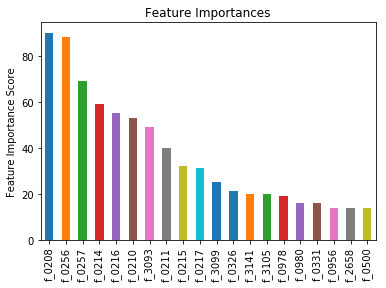

In [311]:
predictors = [x for x in dtrain.columns if x not in [target]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, dtrain, predictors)
#根据每个特征的重要性进行可视化分析

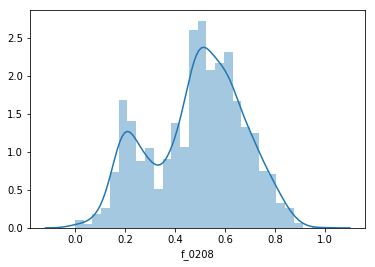

In [319]:
sns.distplot(x_train['f_0208'])

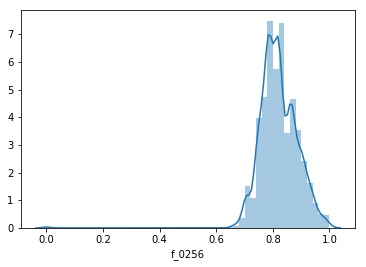

In [318]:
sns.distplot(x_train['f_0256'])
#根据频数分布直方图可以看出大部分特征的的数值分布不均匀，大部分特征的值分布在0和1附近

### 任务4
如果需要在产品中使用。你会推荐使用之前哪个算法得到的模型？解释为什么。

# 任务5

任务1～任务4体现了从得到建模数据，到完成建模实验的环节。

然而，对于整个建模项目来说，以上环节只是一部分工作内容。请候选人根据自己的经验和理解，描述从接到业务部门的需求开始（假设是一个0，1分类的监督式机器学习任务），到监控模型在产品中的使用情况为止，有哪些重要的工作环节？在这些过程中，机器学习建模工程师和业务部门成员如何分工？如何合作？

建议通过流程图配合必要的文字描述，表达自己的理解。


1. 数据建模过程涉及 数据的采集、数据清洗（缺失值处理，异常值处理，样本不平衡处理）、特征工程的构建、模型的选择、调整参数、模型测试以及到模型在产品中的应用等环节。

2. 其中数据的好坏决定机器学习的上限，特征工程的构建和模型调优可以不断逼近这个上限。可见前期的数据的好坏和清洗直接决定了后面步骤的好坏
所以在这些过程中每一步都很重要，业务部门之间要分工明（不同层次的人完成不同的建模环节）确同时也要熟悉各个部门之间的业务，各个部门之间要善于沟通及时反映出现的问题这样有利于工作进程的顺利进行。

# 数据处理

### 任务6

history_df中存放了每个id，在不同time，对应的A, B的数值。

In [167]:
history_data = pd.read_csv('history_data.csv', parse_dates=['time'])
history_data

,id,time,A,B
0,1,2019-01-26 08:52:00,3.797676,8.432960
1,1,2019-01-29 14:59:00,NaN,4.157219
2,1,2019-01-13 00:01:00,6.516694,4.922487
3,1,2019-02-01 00:27:00,2.627256,NaN
4,1,2019-03-26 00:32:00,8.939391,NaN
5,2,2019-01-01 00:14:00,NaN,6.449302
6,2,2019-01-26 00:52:00,3.629338,1.529292
7,2,2019-02-04 00:05:00,4.299086,NaN
8,2,2019-02-28 00:51:00,NaN,3.140770
9,2,2019-03-01 00:44:00,6.353059,5.926424


sample_df存放了一些id和obs_time的组合。

In [168]:
sample_df = pd.read_csv('sample.csv')
sample_df

,id,obs_time
0,1,2019/3/7 0:00
1,1,2019/2/1 0:00
2,2,2019/3/15 0:00
3,2,2019/2/1 0:00


对sample_df中每个id和obs_time的组合，计算离obs_time过去10, 60天内， 该id对应的A, B的最大值, 非空记录数量。将结果存在不同的列中。

例如:

最终的结果包含的列:
* id
* obs_time
* 10天内A平均值
* 10天内A非空样本数量
* 60天内A平均值
* 60天内A非空样本数量
* 10天内B平均值
* 10天内B非空样本数量
* 60天内B平均值
* 60天内B非空样本数量

将计算结果存为excel保存

In [169]:
history_data['time'] = pd.to_datetime(history_data.time) 
sample_df['obs_time']=pd.to_datetime(sample_df.obs_time,errors='coerce')

In [170]:
sample_df

,id,obs_time
0,1,2019-03-07
1,1,2019-02-01
2,2,2019-03-15
3,2,2019-02-01


In [171]:
history_data

,id,time,A,B
0,1,2019-01-26 08:52:00,3.797676,8.432960
1,1,2019-01-29 14:59:00,NaN,4.157219
2,1,2019-01-13 00:01:00,6.516694,4.922487
3,1,2019-02-01 00:27:00,2.627256,NaN
4,1,2019-03-26 00:32:00,8.939391,NaN
5,2,2019-01-01 00:14:00,NaN,6.449302
6,2,2019-01-26 00:52:00,3.629338,1.529292
7,2,2019-02-04 00:05:00,4.299086,NaN
8,2,2019-02-28 00:51:00,NaN,3.140770
9,2,2019-03-01 00:44:00,6.353059,5.926424


In [172]:
sample_df['obs_time'][sample_df['id']==1][0]

Timestamp('2019-03-07 00:00:00')

In [173]:
history_data['time'][history_data['id']==1]

0   2019-01-26 08:52:00
1   2019-01-29 14:59:00
2   2019-01-13 00:01:00
3   2019-02-01 00:27:00
4   2019-03-26 00:32:00
Name: time, dtype: datetime64[ns]

In [174]:
history_data.iloc[0:5,:]

,id,time,A,B
0,1,2019-01-26 08:52:00,3.797676,8.432960
1,1,2019-01-29 14:59:00,NaN,4.157219
2,1,2019-01-13 00:01:00,6.516694,4.922487
3,1,2019-02-01 00:27:00,2.627256,NaN
4,1,2019-03-26 00:32:00,8.939391,NaN


In [175]:
history_data.iloc[5:10,:]

,id,time,A,B
5,2,2019-01-01 00:14:00,NaN,6.449302
6,2,2019-01-26 00:52:00,3.629338,1.529292
7,2,2019-02-04 00:05:00,4.299086,NaN
8,2,2019-02-28 00:51:00,NaN,3.140770
9,2,2019-03-01 00:44:00,6.353059,5.926424


In [176]:
df3=sample_df['obs_time'][sample_df['id']==1][0]-history_data['time'][history_data['id']==1]

In [177]:
df4=sample_df['obs_time'][sample_df['id']==1][1]-history_data['time'][history_data['id']==1]

In [178]:
df5=sample_df['obs_time'][sample_df['id']==2][2]-history_data['time'][history_data['id']==2]

In [179]:
df6=sample_df['obs_time'][sample_df['id']==2][3]-history_data['time'][history_data['id']==2]

In [180]:
df1=history_data.iloc[0:5,:]

In [181]:
df2=history_data.iloc[5:10,:]

In [182]:
pd.concat([df3,df4,df5,df6],axis=0)

0     39 days 15:08:00
1     36 days 09:01:00
2     52 days 23:59:00
3     33 days 23:33:00
4   -20 days +23:28:00
0      5 days 15:08:00
1      2 days 09:01:00
2     18 days 23:59:00
3    -1 days +23:33:00
4   -54 days +23:28:00
5     72 days 23:46:00
6     47 days 23:08:00
7     38 days 23:55:00
8     14 days 23:09:00
9     13 days 23:16:00
5     30 days 23:46:00
6      5 days 23:08:00
7    -4 days +23:55:00
8   -28 days +23:09:00
9   -29 days +23:16:00
Name: time, dtype: timedelta64[ns]

In [183]:
df=pd.concat([df1,df1,df2,df2],axis=0)

In [184]:
df['td']=pd.concat([df3,df4,df5,df6],axis=0)

In [185]:
df

,id,time,A,B,td
0,1,2019-01-26 08:52:00,3.797676,8.432960,39 days 15:08:00
1,1,2019-01-29 14:59:00,NaN,4.157219,36 days 09:01:00
2,1,2019-01-13 00:01:00,6.516694,4.922487,52 days 23:59:00
3,1,2019-02-01 00:27:00,2.627256,NaN,33 days 23:33:00
4,1,2019-03-26 00:32:00,8.939391,NaN,-20 days +23:28:00
0,1,2019-01-26 08:52:00,3.797676,8.432960,5 days 15:08:00
1,1,2019-01-29 14:59:00,NaN,4.157219,2 days 09:01:00
2,1,2019-01-13 00:01:00,6.516694,4.922487,18 days 23:59:00
3,1,2019-02-01 00:27:00,2.627256,NaN,-1 days +23:33:00
4,1,2019-03-26 00:32:00,8.939391,NaN,-54 days +23:28:00


In [186]:
df['obs_time'] = [val for val in sample_df["obs_time"] for i in range(5)]

In [187]:
df

,id,time,A,B,td,obs_time
0,1,2019-01-26 08:52:00,3.797676,8.432960,39 days 15:08:00,2019-03-07
1,1,2019-01-29 14:59:00,NaN,4.157219,36 days 09:01:00,2019-03-07
2,1,2019-01-13 00:01:00,6.516694,4.922487,52 days 23:59:00,2019-03-07
3,1,2019-02-01 00:27:00,2.627256,NaN,33 days 23:33:00,2019-03-07
4,1,2019-03-26 00:32:00,8.939391,NaN,-20 days +23:28:00,2019-03-07
0,1,2019-01-26 08:52:00,3.797676,8.432960,5 days 15:08:00,2019-02-01
1,1,2019-01-29 14:59:00,NaN,4.157219,2 days 09:01:00,2019-02-01
2,1,2019-01-13 00:01:00,6.516694,4.922487,18 days 23:59:00,2019-02-01
3,1,2019-02-01 00:27:00,2.627256,NaN,-1 days +23:33:00,2019-02-01
4,1,2019-03-26 00:32:00,8.939391,NaN,-54 days +23:28:00,2019-02-01


In [188]:
df.dtypes

id                    int64
time         datetime64[ns]
A                   float64
B                   float64
td          timedelta64[ns]
obs_time     datetime64[ns]
dtype: object

In [189]:
df['td']=df['td'].map(lambda x:x.days)

In [193]:
df=df[df['td']>0]

In [ ]:
最终的结果包含的列:
* id
* obs_time
* 10天内A平均值
* 10天内A非空样本数量
* 60天内A平均值
* 60天内A非空样本数量
* 10天内B平均值
* 10天内B非空样本数量
* 60天内B平均值
* 60天内B非空样本数量

将计算结果存为excel保存

In [194]:
df=df.reset_index(drop = True)

In [196]:
df

,id,time,A,B,td,obs_time
0,1,2019-01-26 08:52:00,3.797676,8.432960,39,2019-03-07
1,1,2019-01-29 14:59:00,NaN,4.157219,36,2019-03-07
2,1,2019-01-13 00:01:00,6.516694,4.922487,52,2019-03-07
3,1,2019-02-01 00:27:00,2.627256,NaN,33,2019-03-07
4,1,2019-01-26 08:52:00,3.797676,8.432960,5,2019-02-01
5,1,2019-01-29 14:59:00,NaN,4.157219,2,2019-02-01
6,1,2019-01-13 00:01:00,6.516694,4.922487,18,2019-02-01
7,2,2019-01-01 00:14:00,NaN,6.449302,72,2019-03-15
8,2,2019-01-26 00:52:00,3.629338,1.529292,47,2019-03-15
9,2,2019-02-04 00:05:00,4.299086,NaN,38,2019-03-15


In [197]:
df['c']=['a','a','a','a','b','b','b','c','c','c','c','c','d','d']

In [198]:
df

,id,time,A,B,td,obs_time,c
0,1,2019-01-26 08:52:00,3.797676,8.432960,39,2019-03-07,a
1,1,2019-01-29 14:59:00,NaN,4.157219,36,2019-03-07,a
2,1,2019-01-13 00:01:00,6.516694,4.922487,52,2019-03-07,a
3,1,2019-02-01 00:27:00,2.627256,NaN,33,2019-03-07,a
4,1,2019-01-26 08:52:00,3.797676,8.432960,5,2019-02-01,b
5,1,2019-01-29 14:59:00,NaN,4.157219,2,2019-02-01,b
6,1,2019-01-13 00:01:00,6.516694,4.922487,18,2019-02-01,b
7,2,2019-01-01 00:14:00,NaN,6.449302,72,2019-03-15,c
8,2,2019-01-26 00:52:00,3.629338,1.529292,47,2019-03-15,c
9,2,2019-02-04 00:05:00,4.299086,NaN,38,2019-03-15,c


In [250]:
list=['a', 'b', 'c', 'd']

In [261]:
c1=[df[(df['c']==i)&(df['td']<10)]['A'].mean() for i in list]

In [262]:
c2=[df[(df['c']==i)&(df['td']<10)]['A'].notnull().sum() for i in list]

In [263]:
c3=[df[(df['c']==i)&(df['td']<60)]['A'].mean() for i in list]

In [264]:
c4=[df[(df['c']==i)&(df['td']<60)]['A'].notnull().sum() for i in list]

In [265]:
c5=[df[(df['c']==i)&(df['td']<10)]['B'].mean() for i in list]

In [266]:
c6=[df[(df['c']==i)&(df['td']<10)]['B'].notnull().sum() for i in list]

In [267]:
c7=[df[(df['c']==i)&(df['td']<60)]['B'].mean() for i in list]

In [268]:
c8=[df[(df['c']==i)&(df['td']<60)]['B'].notnull().sum() for i in list]

In [275]:
data={"id":[1,1,2,2],'obs_time':['2019-03-07','2019-02-01','2019-03-15','2019-02-01'],'10天内A平均值':c1,'10天内A非空样本数量':c2 ,
     '60天内A平均值':c3,"60天内A非空样本数量":c4,'10天内B平均值':c5,'10天内B非空样本数量':c6,'60天内B平均值':c7,'60天内B非空样本数量':c8}

In [276]:
data1=pd.DataFrame(data)

In [277]:
data1

,id,obs_time,10天内A平均值,10天内A非空样本数量,60天内A平均值,60天内A非空样本数量,10天内B平均值,10天内B非空样本数量,60天内B平均值,60天内B非空样本数量
0,1,2019-03-07,NaN,0,4.313876,3,NaN,0,5.837555,3
1,1,2019-02-01,3.797676,1,5.157185,2,6.295089,2,5.837555,3
2,2,2019-03-15,NaN,0,4.760495,3,NaN,0,3.532162,3
3,2,2019-02-01,3.629338,1,3.629338,1,1.529292,1,3.989297,2


In [283]:
data1['obs_time']=pd.to_datetime(data1.obs_time) 

In [286]:
data1.to_csv("G:/医学机器学习面试题/data.csv")